In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ase
import ase.io
from scipy.stats import sem, gaussian_kde
%matplotlib inline

In [2]:
data = pd.read_csv('shield_examples/succinic_a_nvt_shieldings.csv', index_col=0)
data

,O1,O2,O3,O4,C1,C2,C3,C4,H1,H2,...,C5err,C6err,C7err,C8err,H7err,H8err,H9err,H10err,H11err,H12err
0,0.0,0.0,0.0,0.0,-11.374640,-1.238473,138.699351,130.715630,14.116591,15.048303,...,0.720672,0.667000,0.551224,1.034476,0.111700,0.182640,0.139513,0.172212,0.129754,0.123356
1,0.0,0.0,0.0,0.0,-13.510551,-19.189747,127.133405,152.520175,18.345571,16.391254,...,0.781859,0.611620,0.685997,0.496847,0.189028,0.207046,0.105895,0.182595,0.102683,0.150429
2,0.0,0.0,0.0,0.0,-18.427711,-19.795940,148.204177,136.225428,9.111565,13.685759,...,1.027195,0.899155,0.843155,0.884652,0.272388,0.197137,0.262713,0.123602,0.123710,0.229681
3,0.0,0.0,0.0,0.0,-8.717913,-6.557254,135.237596,143.270977,9.924948,16.878840,...,0.538761,0.711539,0.485168,0.703904,0.179637,0.201803,0.175316,0.215552,0.120514,0.073468
4,0.0,0.0,0.0,0.0,-13.903023,-13.080796,145.374213,132.767679,12.031938,15.862703,...,0.932077,0.688566,0.642095,0.798322,0.147548,0.164405,0.239095,0.111501,0.106655,0.112083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8001,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,18.016420,21.087913,...,0.000000,0.000000,0.000000,0.000000,0.209325,0.174014,0.070909,0.084356,0.091885,0.108356
8002,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,15.188207,14.581904,...,0.000000,0.000000,0.000000,0.000000,0.207314,0.182268,0.077510,0.104296,0.076961,0.128156
8003,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,16.850478,18.141339,...,0.000000,0.000000,0.000000,0.000000,0.131191,0.117266,0.104995,0.082336,0.081029,0.088535
8004,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,14.254743,12.852404,...,0.000000,0.000000,0.000000,0.000000,0.172258,0.149178,0.098780,0.080353,0.100043,0.081868


## Notes
For benzene_I, after looking at VMD, the equivalent carbons and hydrogens are as follows (along with the corresponding carbon as labelled in the paper):
- C-C3 (C1 in paper) (now C1-C4)
- C4-C7 (C3 in paper) (now C5-C8)
- C8-C11 (C2 in paper)(now C9-C12)
- H0-H3 (H2 in paper) (now H1-H4)
- H4-H7 (H1 in paper) (now H5-H8)
- H8-H11 (H3 in paper) (now H9-H12)

For succinic_alpha, equivalent carbons and hydrogens are as follows:
- C3, C4, C7, C8 (C1 in paper) (methyl C) --INCORRECTLY LABELLED AS CARBOXYL C IN PAPER
- C1, C2, C5, C6 (C2 in paper) (carboxyl C) --INCORRECTLY LABELLED AS METHYL C IN PAPER
- H5, H6, H11, H12 (H1 in paper) (methyl H)
- H3, H4, H9, H10 (H2 in paper) (methyl H)
- H1, H2, H7, H8 (H3 in paper) (carboxyl H)

For glycine_gamma, equivalent carbons and hydrogens are as follows:
- C1-C3 (C1 in paper) (carboxyl C)
- C4-C6 (C2 in paper) (methyl C)
- H1-H3 (H1 in paper) (methyl H)
- H4-H6 (H2 in paper) (methyl H)
- H7-H15 (H3 in paper) (ammonium H)
- N1-N3 (N in paper) (ammonium N)

In [3]:
def remove_zeros(df):
    ## Remove rows with ANY zero values from the pandas dataframe. This might dtop some rows containing non-zero values too.
    df_no_zeros = df[(df != 0).all(1)]
    rows_dropped = len(df)-len(df_no_zeros)
    print("")
    print(str(rows_dropped)+ " rows with zero values dropped.")
    print("")
    print("PLEASE NOTE:")
    print("Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.")
    print("However, if you still have enough frames for converged statistical sampling it shouldn't matter.")
    return df_no_zeros

In [4]:
def process_glycine(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []; num = 0
    for x in ['C1', 'C2', 'C3']:
        C1.extend(df[x])
    C2 = []
    for x in ['C4', 'C5', 'C6']:
        C2.extend(df[x])
    
    N1 = []
    for x in ['N1', 'N2', 'N3']:
        N1.extend(df[x])
    
    H1 = []
    for x in ['H1', 'H2', 'H3']:
        H1.extend(df[x])
    H2 = []
    for x in ['H4', 'H5', 'H6']:
        H2.extend(df[x])
    H3_a = []
    for x in ['H7', 'H8', 'H9']:
        H3_a.extend(df[x])
    H3_b = []
    for x in ['H10', 'H11', 'H12']:
        H3_b.extend(df[x])
    H3_c = []
    for x in ['H13', 'H14', 'H15']:
        H3_c.extend(df[x])
    
    C1err = []
    for x in ['C1err', 'C2err', 'C3err']:
        C1err.extend(df[x])
    C2err = []
    for x in ['C4err', 'C5err', 'C6err']:
        C2err.extend(df[x])
        
    N1err = []
    for x in ['N1err', 'N2err', 'N3err']:
        N1err.extend(df[x])
    
    H1err = []
    for x in ['H1err', 'H2err', 'H3err']:
        H1err.extend(df[x])
    H2err = []
    for x in ['H4err', 'H5err', 'H6err']:
        H2err.extend(df[x])
    H3_aerr = []
    for x in ['H7err', 'H8err', 'H9err']:
        H3_aerr.extend(df[x])
    H3_berr = []
    for x in ['H10err', 'H11err', 'H12err']:
        H3_berr.extend(df[x])
    H3_cerr = []
    for x in ['H13err', 'H14err', 'H15err']:
        H3_cerr.extend(df[x])
    
    zeros=0
    for x in [C1, C2, N1, H1, H2, H3_a, H3_b, H3_c, C1err, C2err, N1err, H1err, H2err, H3_aerr, H3_berr, H3_cerr]:
        for i in range(len(x)):
            if x[i]==0:
                zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
        print("")
    
    print("For glycine, ammonium H nuclei have been split into three. These sets actually have distinct calculated shieldings")
    print("Furthermore, the dataframe could not be created with arrays of different lengths.")
    print("However, please combine these three shieldings into one before further processing, as was done in the paper, because rotation around the C-N bond is faster than the NMR acquisition timescale.")
    processed = {'C1':C1, 'C2':C2, 'N1':N1, 'H1':H1, 'H2': H2, 'H3_a':H3_a,'H3_b':H3_b,'H3_c':H3_c, 'C1err':C1err, 'C2err':C2err, 'N1err':N1err, 'H1err':H1err, 'H2err': H2err, 'H3_aerr':H3_aerr, 'H3_berr':H3_berr, 'H3_cerr':H3_cerr}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df

In [5]:
processed_data_gly=process_glycine('shield_examples/glycine_g_nvt_shieldings.csv')
processed_data_gly = remove_zeros(processed_data_gly)

7272 zero values found. These are likely at the end of the dataframe.
Please remove these before further processing (and don't forget to remove zero values for errors too.)
In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.

For glycine, ammonium H nuclei have been split into three. These sets actually have distinct calculated shieldings
Furthermore, the dataframe could not be created with arrays of different lengths.
However, please combine these three shieldings into one before further processing, as was done in the paper, because rotation around the C-N bond is faster than the NMR acquisition timescale.

1233 rows with zero values dropped.

PLEASE NOTE:
Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.
However, if you still have enough frames for converged statistical sampling it shouldn't matter.


In [6]:
def process_succinic(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []
    for x in ['C3', 'C4', 'C7', 'C8']:
        C1.extend(df[x])
    C2 = []
    for x in ['C1', 'C2', 'C5', 'C6']:
        C2.extend(df[x])
    
    H1 = []
    for x in ['H5', 'H6', 'H11', 'H12']:
        H1.extend(df[x])
    H2 = []
    for x in ['H3', 'H4', 'H9', 'H10']:
        H2.extend(df[x])
    H3 = []
    for x in ['H1', 'H2', 'H7', 'H8']:
        H3.extend(df[x])
    
    C1err = []
    for x in ['C3err', 'C4err', 'C7err', 'C8err']:
        C1err.extend(df[x])
    C2err = []
    for x in ['C1err', 'C2err', 'C5err', 'C6err']:
        C2err.extend(df[x])
    
    H1err = []
    for x in ['H5err', 'H6err', 'H11err', 'H12err']:
        H1err.extend(df[x])
    H2err = []
    for x in ['H3err', 'H4err', 'H9err', 'H10err']:
        H2err.extend(df[x])
    H3err = []
    for x in ['H1err', 'H2err', 'H7err', 'H8err']:
        H3err.extend(df[x])
    
    zeros=0
    for x in [C1, C2, H1, H2, H3, C1err, C2err, H1err, H2err, H3err]:
        for i in range(len(x)):
            if x[i]==0:
                zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
    
    
    processed = {'C1':C1, 'C2':C2, 'H1':H1, 'H2': H2, 'H3':H3, 'C1err':C1err, 'C2err':C2err, 'H1err':H1err, 'H2err': H2err, 'H3err':H3err}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df

In [7]:
processed_data_suc=process_succinic('shield_examples/succinic_a_nvt_shieldings.csv')
processed_data_suc = remove_zeros(processed_data_suc)

8080 zero values found. These are likely at the end of the dataframe.
Please remove these before further processing (and don't forget to remove zero values for errors too.)
In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.

2020 rows with zero values dropped.

PLEASE NOTE:
Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.
However, if you still have enough frames for converged statistical sampling it shouldn't matter.


In [8]:
def process_benzene(raw_data):
    df = pd.read_csv(raw_data, index_col=0)
    
    C1 = []; num = 0
    for x in ['C1', 'C2', 'C3', 'C4']:
        C1.extend(df[x])
    
    C2 = []
    for x in ['C9', 'C10', 'C11', 'C12']:
        C2.extend(df[x])
    C3 = []
    for x in ['C5', 'C6', 'C7', 'C8']:
        C3.extend(df[x])
    
    H2 = []
    for x in ['H1', 'H2', 'H3', 'H4']:
        H2.extend(df[x])
    H1 = []
    for x in ['H5', 'H6', 'H7', 'H8']:
        H1.extend(df[x])
    H3 = []
    for x in ['H9', 'H10', 'H11', 'H12']:
        H3.extend(df[x])
    
    C1err = []
    for x in ['C1err', 'C2err', 'C3err', 'C4err']:
        C1err.extend(df[x])
    C2err = []
    for x in ['C9err', 'C10err', 'C11err', 'C12err']:
        C2err.extend(df[x])
    C3err = []
    for x in ['C5err', 'C6err', 'C7err', 'C8err']:
        C3err.extend(df[x])
    H2err = []
    for x in ['H1err', 'H2err', 'H3err', 'H4err']:
        H2err.extend(df[x])
    H1err = []
    for x in ['H5err', 'H6err', 'H7err', 'H8err']:
        H1err.extend(df[x])
    H3err = []
    for x in ['H9err', 'H10err', 'H11err', 'H12err']:
        H3err.extend(df[x])
    
    zeros=0
    for x in [C1, C2, C3, H1, H2, H3, C1err, C2err, C3err, H1err, H2err, H3err]:
        for i in range(len(x)):
            if x[i]==0:
                zeros += 1
    if zeros != 0:
        print(str(zeros)+" zero values found. These are likely at the end of the dataframe.")
        print("Please remove these before further processing (and don't forget to remove zero values for errors too.)")
        print("In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.")
    
    
    processed = {'C1':C1, 'C2':C2, 'C3':C3, 'H1':H1, 'H2': H2, 'H3':H3, 'C1err':C1err, 'C2err':C2err, 'C3err':C3err, 'H1err':H1err, 'H2err': H2err, 'H3err':H3err}
    processed_df = pd.DataFrame(data=processed)
    
    return processed_df

In [9]:
processed_data_ben=process_benzene('shield_examples/benzene_II_nvt_shieldings.csv')
processed_data_ben= remove_zeros(processed_data_ben)

15984 zero values found. These are likely at the end of the dataframe.
Please remove these before further processing (and don't forget to remove zero values for errors too.)
In future, reduce the nbatch number in calculate_shielding.py to avoid shielding predictions of zero.

1332 rows with zero values dropped.

PLEASE NOTE:
Rows with ANY zero values dropped. This might have dropped some rows containing non-zero values too.
However, if you still have enough frames for converged statistical sampling it shouldn't matter.


array([[<AxesSubplot:title={'center':'C1'}>]], dtype=object)

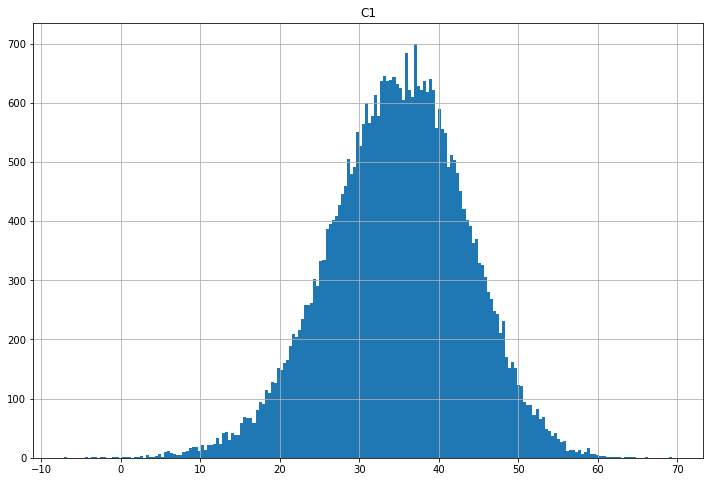

In [10]:
processed_data_ben.hist(column='C1', bins=200, figsize=(12,8))

In [11]:
def plot(df):
    #plot density distribution of shieldings from a dataframe (dataframe must have shielding columns without error columns)
    plt.rcParams["figure.figsize"] = (12,8)
    fig, ax = plt.subplots(nrows=2)
    colours=['blue', 'green', 'black', 'orange']
    lc = 0
    lh = 0
    for i in df.columns:
        #get appropriate x-values
        xs= np.linspace(df.min()[i],df.max()[i],200)
        
        #estimate density from relevant chemical shielding array in dataframe
        normalize = gaussian_kde(df[i])
        normalize.covariance_factor = lambda : .25
        normalize._compute_covariance()
        
        #plot shieldings
        if i[0]=='C' and len(i)<4:
            ax[0].plot(xs, normalize(xs), color=colours[lc])
            ax[0].vlines(np.mean(df[i]), ymin= 0, ymax=max(normalize(xs)+(0.20*normalize(xs))), linestyles="dashed", color=colours[lc])
            lc += 1
        if i[0]=='H'and len(i)<4:
            ax[1].plot(xs, normalize(xs), color=colours[lh])
            ax[1].vlines(np.mean(df[i]), ymin= 0, ymax=max(normalize(xs)+(0.20*normalize(xs))), linestyles="dashed", color=colours[lh])
            lh += 1

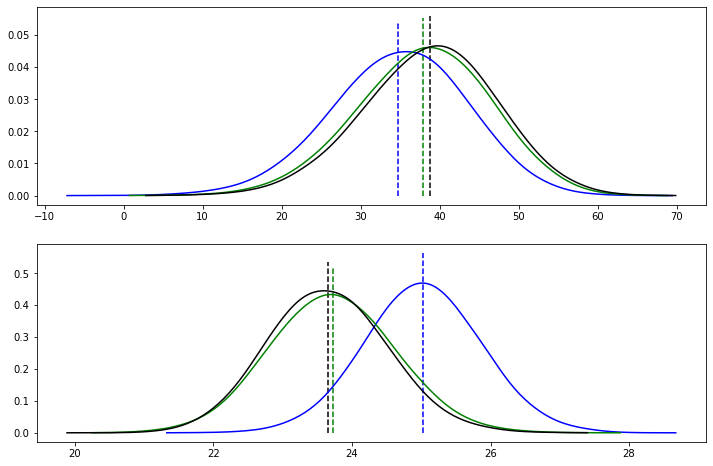

In [12]:
plot(processed_data_ben)

## Error estimation:

- For error estimation of the ML model:
  - The CSerr array has the rescaled standard deviation of each CS prediction
  - Find the standard deviation of the mean (i.e. the ML error of the mean chemical shift), for each chemical environment, using the following formula:
  $$
  \sqrt {\frac{\sum \limits_{i=1} ^N \sigma_i ^{2}}{N}}
  $$
  - Where sigma_i is the standard deviation (CSerr) of the CS prediction. N is the number of samples from the same chemical environment
  - I.e. the error of the mean chemical shift for a certain chemical environment (e.g. C3) is the sum of the squared errors (from CSerr), divided by the sample size, and then square rooted.
- For error estimation from sampling, just take the standard error of the mean
  - This is the mean of the shieldings, divided by the square root of the sample size
  $$
  \frac{\mu}{\sqrt{N}}
  $$
- The two sources of error should be summed to give the total error

## Converting shieldings to shifts:

Convert shieldings to shifts using the following formula:

$$
\delta_{iso} = \sigma_{ref} - Tr(\sigma)
$$

Where:
- delta(iso) is the chemical shift
- Tr(sigma) is the chemical shielding of a certain nuclear environment
- sigma(ref) is the reference chemical shielding (in the case of Edgar's paper, this is taken to be the average chemical shielding of all environments of a certain element)
  - Note that each environment has the same weighting, e.g. if there are two nuclei in environment A, and only one nucleus in environment B, the average chemical shielding will still be (sigma(A)+sigma(B))/2
 
Very important note: To convert experimental shifts to the shifts scale used in the paper, do not apply the same equation as that above (as experimental values are already chemical shifts). Instead, find the average chemical shift $\sigma_{ref}$ and subtract this from the experimental shift $\sigma_{exp}$, i.e. $Adjusted = \sigma_{exp} - \sigma_{ref}$

In [13]:
df=processed_data_gly
for header in df.columns:
        if len(header)<4:
            print(header)

C1
C2
N1
H1
H2


In [14]:
#ML model error estimation:
def calculate_shifts_and_errors(processed_shieldings, glycine=False):
    '''
    Find mean shielding, chemical shift, sampling error, ml error, and total (summed) error by reading a csv or dataframe with processed data (including errors)
    If glycine is being analysed, the process is slightly different, so make sure the argument glycine == True
    '''
    
    # Read csv or dataframe
    if type(processed_shieldings)==str:
        df= pd.read_csv(processed_shieldings, index_col=0)
    elif isinstance(processed_shieldings, pd.DataFrame):
        df= processed_shieldings
    else:
        print('Input file not read.')
    
    shifts_and_errors = pd.DataFrame(columns=['Nucleus','Mean shielding','Chemical shifts', 'Sampling error', 'ML error', 'Total error'])
    mean_shield=[]; nuc=[]; sam_err=[]; ml_err=[]; tot_err=[]; car=[]; hyd=[]; nit=[]; oxy=[]; shifts=[]; nuclei=[]
    
    for header in df.columns:
        if len(header)<4:
            nuclei.append(header)
    if glycine==True:
        nuclei.append('H3')
    
    # Find mean shielding for each element
    for nucleus in nuclei:
        if glycine==True and nucleus=='H3':
            shield_data = list(df['H3_a'])
            shield_data.extend(df['H3_b'])
            shield_data.extend(df['H3_c'])
        else:
            shield_data=df[nucleus]
        
        mean=np.mean(shield_data)
        
        if nucleus[0]=='C':
            car.append(mean)
        if nucleus[0]=='H':
            hyd.append(mean)
        if nucleus[0]=='N':
            nit.append(mean)
        if nucleus[0]=='O':
            oxy.append(mean)
    
    for nucleus in nuclei:
        if glycine==True and nucleus=='H3':
            shield_data = list(df['H3_a'])
            shield_data.extend(df['H3_b'])
            shield_data.extend(df['H3_c'])
            err_data = list(df['H3_aerr'])
            err_data.extend(df['H3_berr'])
            err_data.extend(df['H3_cerr'])
        else:
            shield_data=df[nucleus]
            err_data=df[nucleus+'err']
        
        # Check length of shielding column = length of error column
        if len(shield_data)==len(err_data):
            pass
        else:
            print('Shielding and error sample sizes do not match!!!')
    
        # Get sample size N (number of shielding/error values)
        N= len(shield_data)
        nuc.append(nucleus)
        
        # Get mean shielding for nuclear environment
        mean=np.mean(shield_data)
        mean_shield.append(mean)
        
        # Get error from thermodynamic sampling
        sample_error = np.std(shield_data)/np.sqrt(N)
        sam_err.append(sample_error)
        
        # Get error from the ML method
        ml_error = np.sqrt(np.sum([i**2 for i in err_data])/N)
        ml_err.append(ml_error)
        
        # Combine errors to give total error
        total_error = ml_error + sample_error
        tot_err.append(total_error)
        
        # Convert shielding to shift
        if nucleus[0]=='C':
            shift = np.mean(car)- mean
        if nucleus[0]=='H':
            shift = np.mean(hyd)- mean
        if nucleus[0]=='N':
            shift = np.mean(nit)- mean
        if nucleus[0]=='O':
            shift = np.mean(oxy)- mean
        
        shifts.append(shift)
    
    # Add data to new dataframe
    shifts_and_errors['Nucleus']=nuc
    shifts_and_errors['Mean shielding']=mean_shield
    shifts_and_errors['Sampling error']=sam_err
    shifts_and_errors['ML error']=ml_err
    shifts_and_errors['Total error']=tot_err
    shifts_and_errors['Chemical shifts']=shifts
    
    # Save dataframe as 'shifts_w_errors.csv' -- Uncomment below if you would this functionality
    #shifts_and_errors.to_csv('shifts_w_errors.csv')
    #print('Results (dataframe) returned and saved to file called shifts_w_errors.csv')
    
    return shifts_and_errors

In [15]:
#Experimental shifts
exp_succinic_a = {'C1': 180.8, 'C2': 29}
exp_succinic_b = {'C1': 180.8, 'C2': 29}
exp_glycine_a = {'C1': 176.5, 'C2': 43.4, 'H1': 4.2, 'H2': 3.1, 'H3': 8.4}
exp_glycine_b = {'C1': 175.5, 'C2': 43.2, 'H1': 2.5, 'H2': 2.2, 'H3': 7.4}
exp_glycine_g = {'C1': 174.5, 'C2': 42.4, 'H1': 3.3, 'H2': 3.1, 'H3': 8.8}

#Experimental shifts adjusted -- These used the formula shift - shift(ref) as they were already chemical shifts.
exp_adj_succinic_a = {'C1': 75.9, 'C2': -75.9}
exp_adj_succinic_b = {'C1': 75.9, 'C2': -75.9}
exp_adj_glycine_a = {'C1': 66.55, 'C2': -66.55, 'H1': -1.03, 'H2': -2.13, 'H3': 3.17}
exp_adj_glycine_b = {'C1': 66.15, 'C2': -66.15, 'H1': -1.53, 'H2': -1.83, 'H3': 3.36}
exp_adj_glycine_g = {'C1': 66.05, 'C2': -66.05, 'H1': -1.77, 'H2': -1.97, 'H3': 3.73}

In [16]:
#Geometry optimised shieldings (from Edgar's SI)
geop_shield_benzene_I= {'H1': 25.39, 'H1err': 0.03, 'H2': 24.23, 'H2err': 0.03, 'H3': 24.08, 'H3err': 0.03, 'C1': 38.46, 'C1err': 0.47, 'C2': 41.89, 'C2err': 0.49, 'C3': 42.57, 'C3err': 0.34}
geop_shield_benzene_II= {'H1': 25.79, 'H1err': 0.08, 'H2': 24.24, 'H2err': 0.09, 'H3': 23.76, 'H3err': 0.12, 'C1': 39.80, 'C1err': 0.55, 'C2': 42.10, 'C2err': 0.81, 'C3': 42.10, 'C3err': 0.82}
geop_shield_succinic_a= {'H1': 27.88, 'H1err': 0.04, 'H2': 28.55, 'H2err': 0.05, 'H3': 16.20, 'H3err': 0.05, 'C1': 146.65, 'C1err': 0.29, 'C2': -11.18, 'C2err': 0.26}
geop_shield_succinic_b= {'H1': 27.92, 'H1err': 0.03, 'H2': 28.46, 'H2err': 0.04, 'H3': 16.82, 'H3err': 0.04, 'C1': 146.01, 'C1err': 0.20, 'C2': -10.18, 'C2err': 0.20}
geop_shield_glycine_a= {'H1': 27.09, 'H1err': 0.04, 'H2': 27.76, 'H2err': 0.04, 'H3': 21.41, 'H3err': 0.02, 'C1': -2.64, 'C1err': 0.18, 'C2': 133.46, 'C2err': 0.19, 'N1': 199.84, 'N1err': 0.38}
geop_shield_glycine_b= {'H1': 26.65, 'H1err': 0.27, 'H2': 27.68, 'H2err': 0.28, 'H3': 21.86, 'H3err': 0.24, 'C1': -2.99, 'C1err': 0.55, 'C2': 133.20, 'C2err': 0.84, 'N1': 200.93, 'N1err': 1.50}
geop_shield_glycine_g= {'H1': 26.02, 'H1err': 0.03, 'H2': 27.27, 'H2err': 0.03, 'H3': 21.66, 'H3err': 0.02, 'C1': -6.68, 'C1err': 0.10, 'C2': 131.46, 'C2err': 0.22, 'N1': 199.91, 'N1err': 0.34}

#Geometry optimised shifts 
geop_shift_benzene_I= {'H1': -0.82, 'H1err': 0.03, 'H2': 0.34, 'H2err': 0.03, 'H3': 0.49, 'H3err': 0.03, 'C1': 2.51, 'C1err': 0.47, 'C2': -0.91, 'C2err': 0.49, 'C3': -1.59, 'C3err': 0.34}
geop_shift_benzene_II= {'H1': -1.19, 'H1err': 0.08, 'H2': 0.36, 'H2err': 0.09, 'H3': 0.84, 'H3err': 0.12, 'C1': 1.53, 'C1err': 0.55, 'C2': -0.77, 'C2err': 0.81, 'C3': -0.77, 'C3err': 0.82}
geop_shift_succinic_a= {'H1': -3.67, 'H1err': 0.04, 'H2': -4.34, 'H2err': 0.05, 'H3': 8.01, 'H3err': 0.05, 'C1': -78.92, 'C1err': 0.29, 'C2': 78.92, 'C2err': 0.26}
geop_shift_succinic_b= {'H1': -3.52, 'H1err': 0.03, 'H2': -4.06, 'H2err': 0.04, 'H3': 7.58, 'H3err': 0.04, 'C1': -78.10, 'C1err': 0.20, 'C2': 78.10, 'C2err': 0.20}
geop_shift_glycine_a= {'H1': -1.67, 'H1err': 0.04, 'H2': -2.34, 'H2err': 0.04, 'H3': 4.01, 'H3err': 0.02, 'C1': 68.05, 'C1err': 0.18, 'C2': -68.05, 'C2err': 0.19}
geop_shift_glycine_b= {'H1': -1.25, 'H1err': 0.27, 'H2': -2.28, 'H2err': 0.28, 'H3': 3.54, 'H3err': 0.24, 'C1': 68.10, 'C1err': 0.55, 'C2': -68.10, 'C2err': 0.84}
geop_shift_glycine_g= {'H1': -1.04, 'H1err': 0.03, 'H2': -2.29, 'H2err': 0.03, 'H3': 3.32, 'H3err': 0.02, 'C1': 69.07, 'C1err': 0.10, 'C2': -69.07, 'C2err': 0.22}

In [17]:
##Was just used to convert geop and exp shieldings/shifts dictionaries to the shift scale used for the paper
##New dictionaries were created, so you can ignore this cell
hyd=[];car=[];oxy=[];nit=[]
dic=geop_shield_glycine_g

for i in dic:
        if len(i)<3:
            num = dic[i]
            if i[0]=='C':
                car.append(num)
            if i[0]=='H':
                hyd.append(num)
            if i[0]=='N':
                nit.append(num)
            if i[0]=='O':
                oxy.append(num)

for i in dic:
        if len(i)<3:
            if i[0]=='C':
                shift= np.mean(car)-dic[i]
            if i[0]=='H':
                shift= np.mean(hyd)-dic[i]
            if i[0]=='N':
                shift= np.mean(nit)-dic[i]
            if i[0]=='O':
                shift= np.mean(oxy)-dic[i]
        
            print('The chemical shift for nucleus '+ i + ' is: '+ str(shift))

The chemical shift for nucleus H1 is: -1.0366666666666653
The chemical shift for nucleus H2 is: -2.2866666666666653
The chemical shift for nucleus H3 is: 3.323333333333334
The chemical shift for nucleus C1 is: 69.07
The chemical shift for nucleus C2 is: -69.07000000000001
The chemical shift for nucleus N1 is: 0.0


In [18]:
shifts_w_errors= calculate_shifts_and_errors(processed_data_gly, glycine=True)
shifts_w_errors

,Nucleus,Mean shielding,Chemical shifts,Sampling error,ML error,Total error
0,C1,-4.993411,66.659896,0.052934,0.500866,0.553800
1,C2,128.326380,-66.659896,0.048260,0.905780,0.954039
2,N1,191.321937,0.000000,0.079964,1.169688,1.249652
3,H1,26.545475,-1.707904,0.011535,0.138129,0.149664
4,H2,27.115146,-2.277574,0.010530,0.117195,0.127726
5,H3,20.852094,3.985478,0.013009,0.166162,0.179171


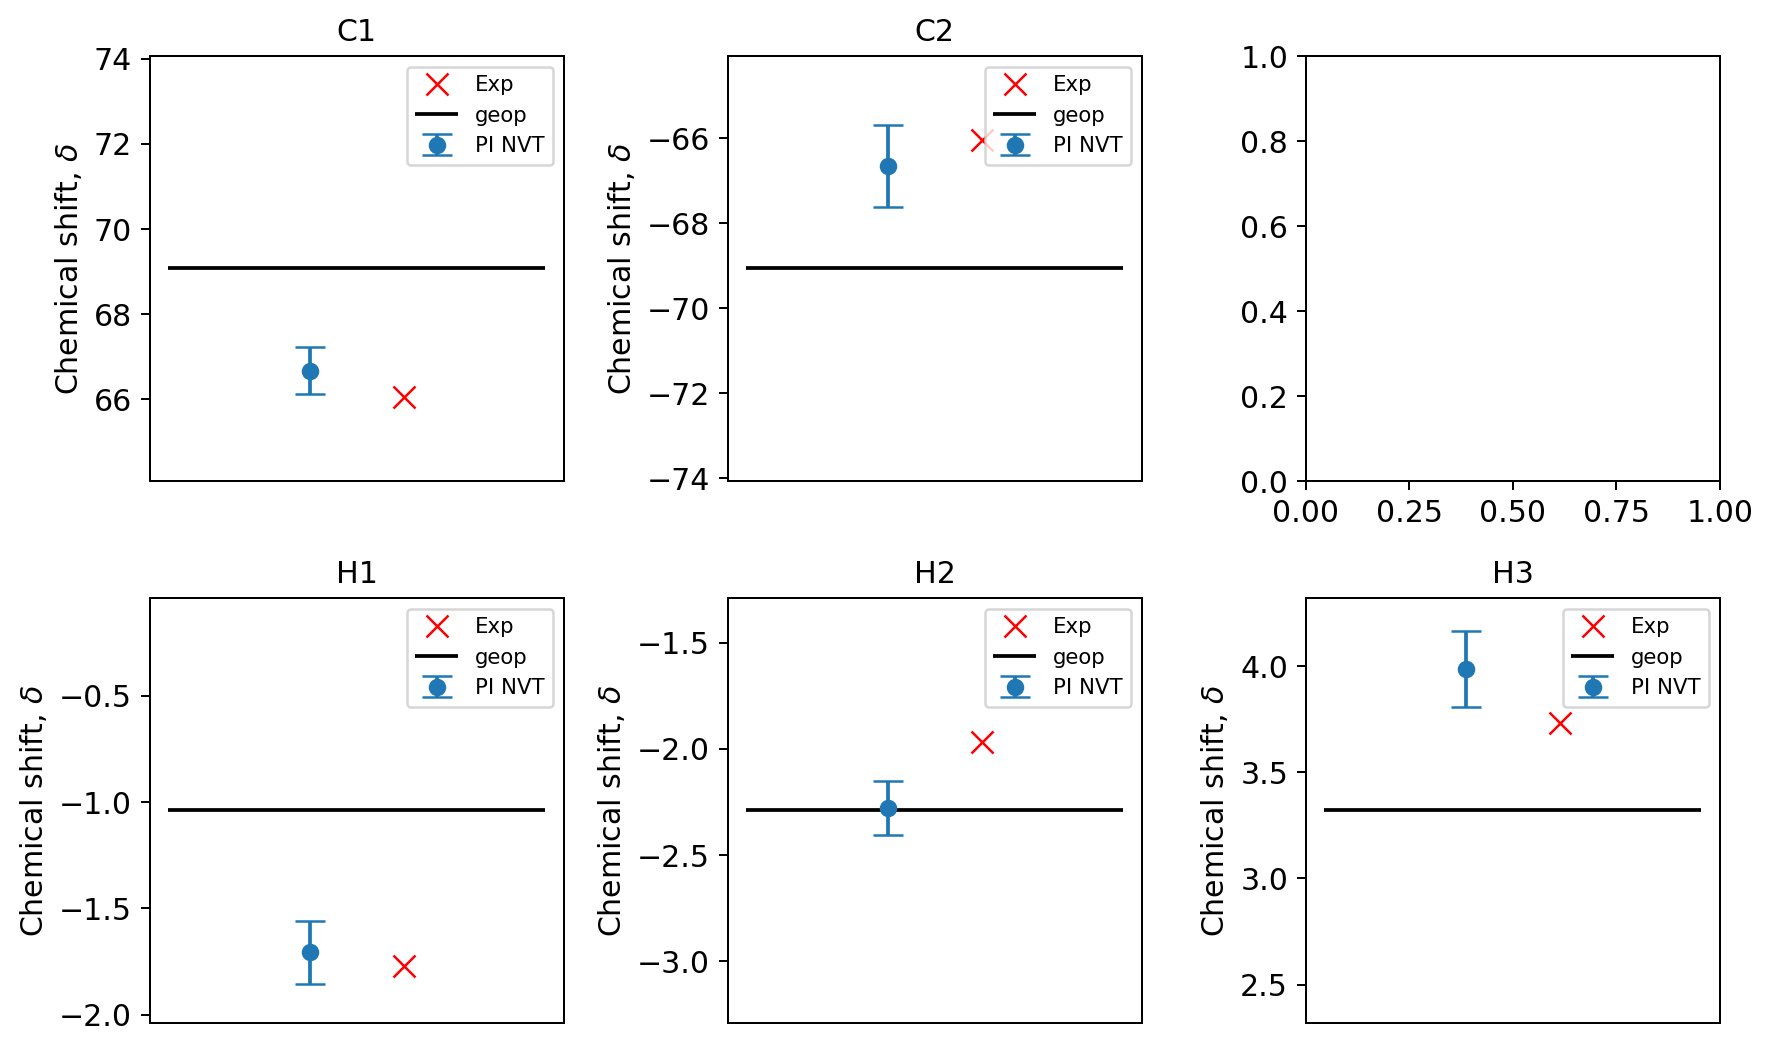

In [22]:
names = shifts_w_errors["Nucleus"]
y = shifts_w_errors["Chemical shifts"]
y_error = shifts_w_errors ["Total error"]

shifts, species = plt.subplots(2, 3, figsize=(10,6), dpi=180)

for i in range(len(names)):
    if names[i][0]=='C' or names[i][0]=='N':
        pl1=0
        pl2=i
        ran=5
    elif names[i][0]=='H':
        pl1=1
        pl2=i-3
        ran=1
    
    if names[i][0]=='C' or names[i][0]=='H':
        horizontal= geop_shift_glycine_g[names[i]]
        experimental = exp_adj_glycine_g[names[i]]
        species[pl1,pl2].errorbar(-0.25, y[i], yerr= y_error[i], xerr=None, fmt='o', capsize=6, label='PI NVT')
        species[pl1,pl2].plot(0.25, experimental, 'ro', color='red', marker='x', markersize=9, label='Exp')
        species[pl1,pl2].hlines(y=horizontal, xmin=-1, xmax=1, label='geop', color='black')
        species[pl1,pl2].axes.xaxis.set_visible(False)
        species[pl1,pl2].legend(loc=1, prop={'size': 8.5})
        species[pl1,pl2].set(title= names[i], ylim=(horizontal-ran, horizontal+ran), ylabel='Chemical shift, '+r'$\delta$')
        for item in ([species[pl1,pl2].title, species[pl1,pl2].xaxis.label, species[pl1,pl2].yaxis.label] +
             species[pl1,pl2].get_xticklabels() + species[pl1,pl2].get_yticklabels()):
            item.set_fontsize(12)
            
shifts.tight_layout()

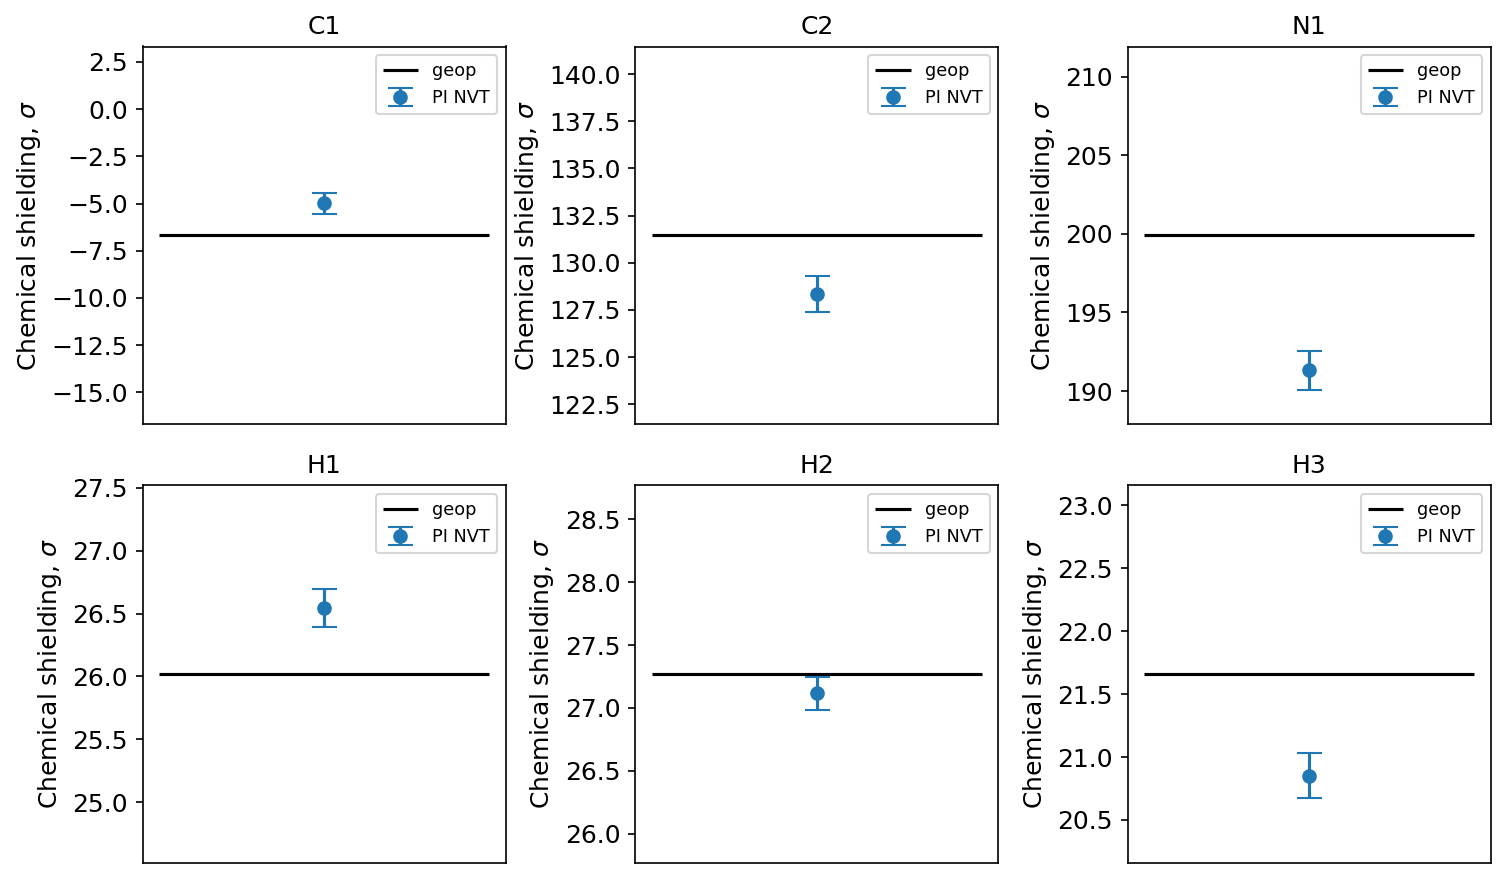

In [20]:
names = shifts_w_errors["Nucleus"]
x = 0
y = shifts_w_errors["Mean shielding"]
y_error = shifts_w_errors ["Total error"]
shifts, species = plt.subplots(2, 3, figsize=(10,6), dpi=150)

for i in range(len(names)):
    if names[i][0]=='C':
        pl1=0
        pl2=i
        ran=10
    elif names[i][0]=='N':
        pl1=0
        pl2=i
        ran=12
    elif names[i][0]=='H':
        pl1=1
        pl2=i-3
        ran=1.5
    horizontal= geop_shield_glycine_g[names[i]]
    species[pl1,pl2].errorbar(0, y[i], yerr= y_error[i], xerr=None, fmt='o', capsize=6, label='PI NVT')
    species[pl1,pl2].hlines(y=horizontal, xmin=-1, xmax=1, label='geop', color='black')
    species[pl1,pl2].axes.xaxis.set_visible(False)
    species[pl1,pl2].legend(loc=1, prop={'size': 8.5})
    species[pl1,pl2].set(title= names[i], ylim=(horizontal-ran, horizontal+ran), ylabel='Chemical shielding, '+r'$\sigma$')
    for item in ([species[pl1,pl2].title, species[pl1,pl2].xaxis.label, species[pl1,pl2].yaxis.label] +
         species[pl1,pl2].get_xticklabels() + species[pl1,pl2].get_yticklabels()):
        item.set_fontsize(12)
            
shifts.tight_layout()

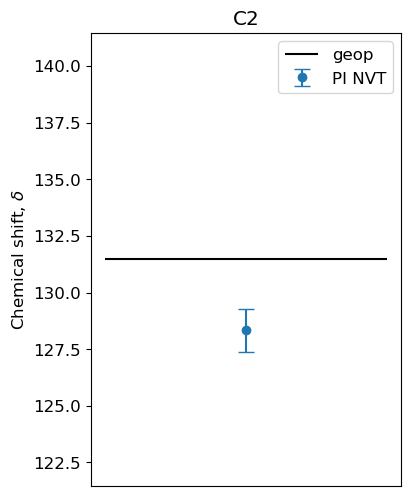

In [21]:
names = shifts_w_errors["Nucleus"]
x = 0
y = shifts_w_errors["Mean shielding"]
y_error = shifts_w_errors ["Total error"]

ran= 10 # Change this to alter the y-axis range. Need a larger range for C and N (~10) than for H (~2)
i = 1 # Change this to alter the chosen nucleus for the plot
horizont= geop_shield_glycine_g[names[i]] # Change the chosen dictionary depending on the compound you're plotting!

fig=plt.figure(figsize=(4,6), dpi=100)
plt.rcParams.update({'font.size': 12})
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.errorbar(0, y[i], yerr= y_error[i], xerr=None, fmt='o', capsize=6, label='PI NVT')
plt.hlines(y=horizont, xmin=-1, xmax=1, label='geop', color='black')
plt.legend(loc=1, prop={'size': 12})
plt.title(names[i])
plt.ylim(horizont-ran, horizont+ran)
plt.ylabel('Chemical shift, '+r'$\delta$')

plt.xticks
shifts.tight_layout()